In [1]:
#https://github.com/MapleFrogStudio/algo_vibes_SP500_RSI
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import pandas_ta as ta
import numpy as np
from datetime import datetime, date

In [2]:
# def grab_symbols():
#     # Grab S&P Symbols from Wikipedia or local HTML File
#     # wiki_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
#     # wiki_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies#S&P_500_component_stocks'
#     tickers = pd.read_html('./tickers.html')[0]
#     tickers = tickers.Symbol.to_list()
#     tickers = [i.replace('.','-') for i in tickers]
#     return tickers 

# print('Grab symbols function defined...')

In [3]:
def yahoo_prices(tickers, current_day): 
    # Return a DataFrame with dates, symbols and prices
    if not isinstance(tickers,list):
        return None

    years_back = 3
    start_dt = '2020-01-01' #date(end_dt.year - years_back, end_dt.month, end_dt.day)
    end_dt = '2023-04-30'#datetime.strptime(current_day, '%Y-%m-%d').date()
   
    data = yf.download(tickers, start=start_dt, end=end_dt)
    data = data.loc[(slice(None)),(slice(None),slice(None))].copy()
    data = data.stack()
    data = data.reset_index()
    data.rename(columns={'level_1': 'Symbol'}, inplace=True)
    data.set_index('Date', inplace=True)
    return data

print('Yahoo_prices function defined...')

Yahoo_prices function defined...


In [4]:
# Grab symbols and get prices from yahoo
tickers = ['AAPL','MSFT','GOOGL']#,'SPY']#,'BAC','TJX','AMD']#grab_symbols()
test_length = len(tickers)
all_assets = yahoo_prices(tickers[0:test_length], '2023-01-31')

[*********************100%***********************]  3 of 3 completed


In [5]:
all_assets

Symbol   Adj Close       Close        High         Low        Open  \
Date                                                                            
2019-12-31   AAPL   71.810928   73.412498   73.419998   72.379997   72.482498   
2019-12-31  GOOGL   66.969498   66.969498   67.032997   66.606499   66.789497   
2019-12-31   MSFT  152.930130  157.699997  157.770004  156.449997  156.770004   
2020-01-02   AAPL   73.449409   75.087502   75.150002   73.797501   74.059998   
2020-01-02  GOOGL   68.433998   68.433998   68.433998   67.324501   67.420502   
...           ...         ...         ...         ...         ...         ...   
2023-04-27  GOOGL  107.589996  107.589996  108.370003  103.540001  104.449997   
2023-04-27   MSFT  304.829987  304.829987  305.200012  295.250000  295.970001   
2023-04-28   AAPL  169.679993  169.679993  169.850006  167.880005  168.490005   
2023-04-28  GOOGL  107.339996  107.339996  107.349998  105.089996  107.040001   
2023-04-28   MSFT  307.260010  307.260010  308.929993  303.309998  304.010010   

               Volume  
Date                   
2019-12-31  100805600  
2019-12-31   19514000  
2019-12-31   18369400  
2020-01-02  135480400  
2020-01-02   27278000  
...               ...  
2023-04-27   50089200  
2023-04-27   46462600  
2023-04-28   55209200  
2023-04-28   36123700  
2023-04-28   36446700  

[2514 rows x 7 columns]

In [6]:
all_assets.isnull().sum()

Symbol       0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

In [7]:
# Generate our indicators for Buy Signals for each of our assets
# df: contains one company (symbol) of data
def add_indicators(df):
    # Sanity check for our indicators to work
    #if len(df) < 250:
        #return None
    
    df['NextOpen'] = df.Open.shift(-1)
    df['NextDate'] = df.index
    df['NextDate'] = df.NextDate.shift(-1)
    df['MA200'] = df['Close'].rolling(window=16).mean()
    
    df['Price_change'] = df['Close'].pct_change()
    df['Upmove']   = df['Price_change'].apply(lambda x: x if x > 0 else 0)
    df['Downmove'] = df['Price_change'].apply(lambda x: abs(x) if x < 0 else 0)
    df['Avg_up']   = df['Upmove'].ewm(span=10).mean()
    df['Avg_down']   = df['Downmove'].ewm(span=10).mean()
    
    df = df.dropna().copy()
    df['RS'] = df['Avg_up'] / df['Avg_down']
    df['RSI'] = df['RS'].apply(lambda x: 100 - (100 / (x + 1)))

    # df.loc[(df['Close'] > df['MA200']) & (df['RSI'] < 30), 'Buy_signal' ] = 'Yes'
    # df.loc[(df['Close'] <= df['MA200']) | (df['RSI'] >= 30), 'Buy_signal' ] = 'No'

    return df
    
print('add_RSI_buy_signals function defined....')

add_RSI_buy_signals function defined....


In [8]:
def add_buy_signals(df):
    buy_filter = (df['Close'] > df['MA200']) & (df['RSI'] < 50)
    df.loc[buy_filter, 'Buy_signal' ] = 'Yes'
    df.loc[(df['Close'] <= df['MA200']) | (df['RSI'] >= 50), 'Buy_signal' ] = 'No'


    return df

def add_sell_signals(df):
    
    pass

def generate_orders(df):
    pass


In [9]:
def order_simuator(df):
    max_hold_days = 5    # hold position for a maximum of 10 days
    stop_loss_percentage = 1.2419 *-0.02
    target_percentage = 2.4844 *0.02
    # Order actions : Enter, Skip, Close, Stop, Target (a buy signal will be skipped if already in position)
    df['Order'] = ''

    in_position_start_index = None
    for index, row in df.iterrows():
        # Check for Enter position conditions
        if row.Buy_signal == 'Yes' and in_position_start_index is None:
            df.at[index, 'Order'] = 'Enter'
            in_position_start_index = index
        elif row.Buy_signal == 'Yes' and in_position_start_index is not None:
            df.at[index, 'Order'] = 'Skip'
        
        # Check for exit position conditions
        if in_position_start_index is not None:
            if (index - in_position_start_index).days >= max_hold_days:
                df.at[index, 'Order'] = 'Close'
                in_position_start_index = None
            elif index > in_position_start_index: 
                buy_price = df.at[in_position_start_index, 'Close']
                current_price = row['Close']
                percent_change = (current_price - buy_price) / buy_price
                if percent_change < stop_loss_percentage:
                    df.at[index, 'Order'] = 'Stop'
                    in_position_start_index = None
                if percent_change > target_percentage:
                    df.at[index, 'Order'] = 'Target'
                    in_position_start_index = None

    return df

print('Order simulator function defined....')

Order simulator function defined....


In [10]:
def extract_trades(df):
    # Loop through frame order information
    ## Grab Enter row to add to our trade dict
    ## Grab Sell row (Close, Target, Stop) to add to our ENTER row
    ## append to our trades
    ## Convert to a DataFrame
    # trade = {Id:999, Trade_seq: Tade_seq, Symbol: Ticker, Buy_dt: Date, Buy_Price: Price, Sell_dt: Date, Sell_Price: Price, Sell_Trigger: Close }
    # Id = symbol_Sort
    
    trades = []
    open_position = False
    trade_sequence = 1
    for index, row in df.iterrows():
        if not open_position: # Get the next Entry row
            if row.Order == 'Enter':
                trade_seq = trade_sequence
                symbol = row.Symbol
                buy_dt = row.NextDate
                buy_price = row.NextOpen
                open_position = True
        else: # Get the next Sell row (Close, Target, Stop)
            if row.Order in ['Close','Target','Stop']:
                sell_dt = row.NextDate
                sell_price = row.NextOpen
                sell_type = row.Order
                days_in_trade = (sell_dt - buy_dt).days
                profit = sell_price - buy_price
                percent_return = profit / buy_price
                trade = {'Id':f'{symbol}-{trade_seq}','Trade_seq':trade_seq,'Symbol':symbol,\
                         'Buy_dt':buy_dt,'Buy_Price':buy_price,\
                         'Sell_dt':sell_dt,'Sell_Price':sell_price,'Sell_type':sell_type,\
                         'Duration':days_in_trade,'profit':profit,'return':percent_return\
                        }
                trades.append(trade)
                open_position = False
                trade_sequence += 1
    trades_df = pd.DataFrame(trades)
    #print(trades_df)
    return trades_df

print('Extract Trades function defined....')  

Extract Trades function defined....


In [11]:
# add indicators and buy signals, generate orders and store detailed results by date and symbol in an easily accessible list
multi_assets = []
len_tickers = len(tickers[0:test_length])
for i in range(len_tickers):
    frame = all_assets.loc[all_assets.Symbol == tickers[i]].copy()
    frame = add_indicators(frame)
    frame = add_buy_signals(frame)
    if frame is not None:
        frame = order_simuator(frame)
        multi_assets.append(frame)

In [12]:
all_trades = None
for i in range(len(multi_assets)):
    frame = multi_assets[i]
    trades = extract_trades(frame)
    if all_trades is None:
        all_trades = trades
    else:    
        all_trades = pd.concat([all_trades, trades], axis=0, ignore_index=True)


wining_trades = len(all_trades.loc[all_trades.profit > 0])
losing_trades = len(all_trades.loc[all_trades.profit < 0])
target_trades = len(all_trades.loc[all_trades.Sell_type == 'Target'])
stop_trades   = len(all_trades.loc[all_trades.Sell_type == 'Stop'])
close_trades  = len(all_trades.loc[all_trades.Sell_type == 'Close'])
print(f'Wining trades: {wining_trades}')
print(f'Losing trades: {losing_trades}')
print(f'Targets: {target_trades}, Stops: {stop_trades}, Closes: {close_trades}')
print(f'Total profit : ${all_trades.profit.sum():0.2f}')
all_trades

Wining trades: 40
Losing trades: 16
Targets: 7, Stops: 7, Closes: 42
Total profit : $103.20


Id  Trade_seq Symbol     Buy_dt   Buy_Price    Sell_dt  Sell_Price  \
0     AAPL-1          1   AAPL 2020-04-22   68.402496 2020-04-27   70.449997   
1     AAPL-2          2   AAPL 2020-06-29   88.312500 2020-07-02   91.962502   
2     AAPL-3          3   AAPL 2020-10-05  113.910004 2020-10-08  116.250000   
3     AAPL-4          4   AAPL 2020-10-21  116.669998 2020-10-27  115.489998   
4     AAPL-5          5   AAPL 2020-11-23  117.180000 2020-11-24  113.910004   
5     AAPL-6          6   AAPL 2020-12-15  124.339996 2020-12-16  127.410004   
6     AAPL-7          7   AAPL 2021-01-05  128.889999 2021-01-12  128.500000   
7     AAPL-8          8   AAPL 2021-02-02  135.729996 2021-02-09  136.619995   
8     AAPL-9          9   AAPL 2021-04-23  132.160004 2021-04-28  134.309998   
9    AAPL-10         10   AAPL 2021-07-20  143.460007 2021-07-27  149.119995   
10   AAPL-11         11   AAPL 2021-11-29  159.369995 2021-12-01  167.479996   
11   AAPL-12         12   AAPL 2021-12-20  168.279999 2021-12-23  175.850006   
12   AAPL-13         13   AAPL 2022-02-11  172.330002 2022-02-16  171.850006   
13   AAPL-14         14   AAPL 2022-04-07  171.160004 2022-04-12  168.020004   
14   AAPL-15         15   AAPL 2022-06-06  147.029999 2022-06-09  147.080002   
15   AAPL-16         16   AAPL 2022-10-28  148.199997 2022-10-31  153.160004   
16   AAPL-17         17   AAPL 2022-11-28  145.139999 2022-11-29  144.289993   
17   AAPL-18         18   AAPL 2023-04-11  162.350006 2023-04-18  166.100006   
18    MSFT-1          1   MSFT 2020-04-22  171.389999 2020-04-28  175.589996   
19    MSFT-2          2   MSFT 2020-05-14  177.539993 2020-05-19  185.029999   
20    MSFT-3          3   MSFT 2020-06-12  190.539993 2020-06-17  195.029999   
21    MSFT-4          4   MSFT 2020-07-14  206.130005 2020-07-21  213.660004   
22    MSFT-5          5   MSFT 2020-08-14  208.759995 2020-08-19  211.490005   
23    MSFT-6          6   MSFT 2020-10-05  207.220001 2020-10-08  210.509995   
24    MSFT-7          7   MSFT 2020-10-20  215.800003 2020-10-27  211.589996   
25    MSFT-8          8   MSFT 2020-11-18  213.649994 2020-11-24  209.589996   
26    MSFT-9          9   MSFT 2020-12-04  214.220001 2020-12-09  215.160004   
27   MSFT-10         10   MSFT 2021-06-02  248.130005 2021-06-08  255.160004   
28   MSFT-11         11   MSFT 2021-07-20  278.029999 2021-07-27  289.429993   
29   MSFT-12         12   MSFT 2021-08-11  287.209991 2021-08-17  292.390015   
30   MSFT-13         13   MSFT 2021-09-08  299.779999 2021-09-14  299.559998   
31   MSFT-14         14   MSFT 2022-01-04  334.829987 2022-01-06  313.149994   
32   MSFT-15         15   MSFT 2022-07-01  256.390015 2022-07-06  263.750000   
33   MSFT-16         16   MSFT 2022-08-22  282.079987 2022-08-23  276.440002   
34   MSFT-17         17   MSFT 2022-11-29  241.399994 2022-12-01  253.869995   
35   MSFT-18         18   MSFT 2023-02-17  259.390015 2023-02-22  254.089996   
36   MSFT-19         19   MSFT 2023-04-12  284.790009 2023-04-18  291.570007   
37   GOOGL-1          1  GOOGL 2020-04-22   62.055500 2020-04-27   64.599998   
38   GOOGL-2          2  GOOGL 2020-05-14   66.676003 2020-05-19   69.274002   
39   GOOGL-3          3  GOOGL 2020-06-05   70.781998 2020-06-10   73.075500   
40   GOOGL-4          4  GOOGL 2020-07-24   74.959503 2020-07-29   75.250000   
41   GOOGL-5          5  GOOGL 2020-10-08   73.272499 2020-10-13   78.850502   
42   GOOGL-6          6  GOOGL 2020-11-23   87.011002 2020-11-27   88.226997   
43   GOOGL-7          7  GOOGL 2021-01-14   87.443497 2021-01-20   91.318497   
44   GOOGL-8          8  GOOGL 2021-01-28   91.550003 2021-02-02   95.656502   
45   GOOGL-9          9  GOOGL 2021-02-23  100.699501 2021-03-02  103.241997   
46  GOOGL-10         10  GOOGL 2021-04-23  113.349998 2021-04-28  119.625000   
47  GOOGL-11         11  GOOGL 2021-05-05  116.431503 2021-05-11  112.153503   
48  GOOGL-12         12  GOOGL 2021-06-21  120.500504 2021-06-24  122.699997   
49  GOOGL-

In [13]:
all_trades.Sell_type.value_counts()

Close     42
Target     7
Stop       7
Name: Sell_type, dtype: int64

In [14]:
all_trades[all_trades['Sell_type'] == 'Stop']

Id  Trade_seq Symbol     Buy_dt   Buy_Price    Sell_dt  Sell_Price  \
4     AAPL-5          5   AAPL 2020-11-23  117.180000 2020-11-24  113.910004   
16   AAPL-17         17   AAPL 2022-11-28  145.139999 2022-11-29  144.289993   
31   MSFT-14         14   MSFT 2022-01-04  334.829987 2022-01-06  313.149994   
33   MSFT-16         16   MSFT 2022-08-22  282.079987 2022-08-23  276.440002   
50  GOOGL-14         14  GOOGL 2021-12-14  143.968002 2021-12-20  140.000000   
51  GOOGL-15         15  GOOGL 2022-02-11  138.600006 2022-02-14  133.256500   
53  GOOGL-17         17  GOOGL 2022-07-13  111.700996 2022-07-15  112.000504   

   Sell_type  Duration     profit    return  
4       Stop         1  -3.269997 -0.027906  
16      Stop         1  -0.850006 -0.005856  
31      Stop         2 -21.679993 -0.064749  
33      Stop         1  -5.639984 -0.019994  
50      Stop         6  -3.968002 -0.027562  
51      Stop         3  -5.343506 -0.038553  
53      Stop         2   0.299507  0.002681

In [15]:
all_trades[all_trades['Sell_type'] == 'Target']

Id  Trade_seq Symbol     Buy_dt   Buy_Price    Sell_dt  Sell_Price  \
0     AAPL-1          1   AAPL 2020-04-22   68.402496 2020-04-27   70.449997   
5     AAPL-6          6   AAPL 2020-12-15  124.339996 2020-12-16  127.410004   
10   AAPL-11         11   AAPL 2021-11-29  159.369995 2021-12-01  167.479996   
15   AAPL-16         16   AAPL 2022-10-28  148.199997 2022-10-31  153.160004   
34   MSFT-17         17   MSFT 2022-11-29  241.399994 2022-12-01  253.869995   
37   GOOGL-1          1  GOOGL 2020-04-22   62.055500 2020-04-27   64.599998   
54  GOOGL-18         18  GOOGL 2022-11-29   95.730003 2022-12-01  101.019997   

   Sell_type  Duration     profit    return  
0     Target         5   2.047501  0.029933  
5     Target         1   3.070007  0.024690  
10    Target         2   8.110001  0.050888  
15    Target         3   4.960007  0.033468  
34    Target         2  12.470001  0.051657  
37    Target         5   2.544498  0.041004  
54    Target         2   5.289993  0.055260

In [16]:
df5 = all_trades[all_trades['Buy_dt']>'2023-01-31']

In [17]:
all_trades['return']

0     0.029933
1     0.041331
2     0.020543
3    -0.010114
4    -0.027906
5     0.024690
6    -0.003026
7     0.006557
8     0.016268
9     0.039453
10    0.050888
11    0.044985
12   -0.002785
13   -0.018345
14    0.000340
15    0.033468
16   -0.005856
17    0.023098
18    0.024505
19    0.042188
20    0.023565
21    0.036530
22    0.013077
23    0.015877
24   -0.019509
25   -0.019003
26    0.004388
27    0.028332
28    0.041003
29    0.018036
30   -0.000734
31   -0.064749
32    0.028706
33   -0.019994
34    0.051657
35   -0.020433
36    0.023807
37    0.041004
38    0.038965
39    0.032402
40    0.003875
41    0.076127
42    0.013975
43    0.044314
44    0.044855
45    0.025248
46    0.055360
47   -0.036743
48    0.018253
49    0.011332
50   -0.027562
51   -0.038553
52   -0.005376
53    0.002681
54    0.055260
55    0.020043
Name: return, dtype: float64

In [18]:
all_trades['return'].cumsum(), all_trades['return'].mean()

(0     0.029933
 1     0.071264
 2     0.091806
 3     0.081692
 4     0.053786
 5     0.078477
 6     0.075451
 7     0.082008
 8     0.098276
 9     0.137730
 10    0.188618
 11    0.233602
 12    0.230817
 13    0.212471
 14    0.212811
 15    0.246280
 16    0.240423
 17    0.263522
 18    0.288027
 19    0.330215
 20    0.353779
 21    0.390310
 22    0.403387
 23    0.419264
 24    0.399755
 25    0.380752
 26    0.385140
 27    0.413472
 28    0.454475
 29    0.472510
 30    0.471776
 31    0.407027
 32    0.435733
 33    0.415739
 34    0.467396
 35    0.446964
 36    0.470771
 37    0.511774
 38    0.550739
 39    0.583141
 40    0.587016
 41    0.663143
 42    0.677118
 43    0.721433
 44    0.766288
 45    0.791536
 46    0.846896
 47    0.810153
 48    0.828406
 49    0.839738
 50    0.812176
 51    0.773623
 52    0.768247
 53    0.770928
 54    0.826187
 55    0.846231
 Name: return, dtype: float64,
 0.015111259668175137)

<AxesSubplot:>

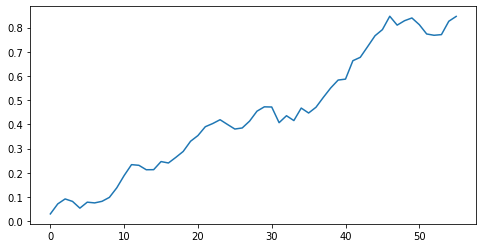

In [19]:
all_trades['return'].cumsum().plot(figsize=(8,4))

In [20]:
sharpe = all_trades['return'].mean()/all_trades['return'].std()
sharpe

0.5400444375722327

In [21]:
r1 = all_trades['return']/0.02
sqn = (r1.mean()/r1.std()) * np.sqrt(r1.size/3)
sqn

2.333258643682101

In [22]:
df5['return'].cumsum(), df5['return'].mean()

(17    0.023098
 35    0.002666
 36    0.026473
 55    0.046516
 Name: return, dtype: float64,
 0.011628920216181001)

In [23]:
df5['return']

17    0.023098
35   -0.020433
36    0.023807
55    0.020043
Name: return, dtype: float64

In [24]:
df5

Id  Trade_seq Symbol     Buy_dt   Buy_Price    Sell_dt  Sell_Price  \
17   AAPL-18         18   AAPL 2023-04-11  162.350006 2023-04-18  166.100006   
35   MSFT-18         18   MSFT 2023-02-17  259.390015 2023-02-22  254.089996   
36   MSFT-19         19   MSFT 2023-04-12  284.790009 2023-04-18  291.570007   
55  GOOGL-19         19  GOOGL 2023-03-29  102.279999 2023-04-04  104.330002   

   Sell_type  Duration    profit    return  
17     Close         7  3.750000  0.023098  
35     Close         5 -5.300018 -0.020433  
36     Close         6  6.779999  0.023807  
55     Close         6  2.050003  0.020043